<a href="https://colab.research.google.com/github/RafaelVendiciano/Portfolio/blob/master/Detec%C3%A7%C3%A3o_de_Fraude_em_Cart%C3%B5es_de_Cr%C3%A9dito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecção de Fraudes em Cartões de Crédito

Neste projeto, iremos abordar o problema das fraudes em cartões de crédito, uma das principais preocupações das instituições financeiras como bancos e *fintechs*. Apenas no Brasil, cerca de 12,1 milhões de pessoas já foram vítimas de algum tipo de fraude financeira no último ano. Traduzindo em valores, os golpes financeiros ultrapassaram a cifra de R$ 1,8 bilhão de prejuízo por ano para os últimos 12 meses.

<p align=center>
<img src="http://sigmoidal.ai/wp-content/uploads/2019/12/900.jpg" width="60%"></p>

Dentre essas fraudes, aquelas envolvendo cartões de crédito são de grande relevância uma vez que a sua não-detecção acaretará em prejuízos consideráveis, tanto para o consumidor quanto para a instituição financeira.

Um outro fator a ser considerado é a quantidade de falsos positivos, ou seja, aquelas vezes em que você tentou fazer uma compra e teve seu cartão bloqueado preventivamente - o que provavelmente gerou estresse e constrangimento.

Por todos esses motivos, o investimento na área de detecção de fraudes por meio de Inteligência Artificial vem crescendo a cada ano, representando uma grande oportunidade em *Data Science*. 

Dispondo de grandes volumes de dados como base histórica, um algoritmo de machine learning apenas um pouco melhor que os anteriores já representa uma economia de milhões de Reais. E esse é o desafio, aprimorar cada vez mais o uso de algoritmos visando inibir ou evitar transações fraudulentas.

## Importando os Dados

Os dados que usaremos neste projeto foram disponibilizados por algumas empresas européias de cartão de crédito. O *dataset* representa as operações financeiras que aconteceram no período de dois dias, onde foram classificadas 492 fraudes em meio a quase 290 mil transações.

Como você pode notar, este é um conjunto de dados extremamente desbalanceado, onde as fraudes representam apenas 0,17% do total.

Outro detalhe interessante é que as *features* são todas numéricas, e foram descaracterizadas (por problemas ligados à privacidade e segurança). Assim, os nomes das colunas são representados por $[V1, V2, V3 \dots, V28]$ 

<p align=center>
<img src="http://sigmoidal.ai/wp-content/uploads/2019/12/54.jpg" width="50%"></p>

[Na página original dos dados](https://www.kaggle.com/mlg-ulb/creditcardfraud), também é informado que as variáveis passaram por uma transformação conhecida como Análise de Componentes Principais (*Principal Component Analysis* - PCA).

A PCA permite a redução da dimensionalidade enquanto mantém o maior número possível de informações. Para conseguir isso, o algoritmo encontra um conjunto novo de recursos - os chamados **componentes**.

Esses componentes são em número menor or igual às variáveis originais. No caso deste projeto, os componentes achados pela transformação da PCA são as próprias colunas $[V1, V2, V3 \dots, V28]$.

In [3]:
#@title
# suprimir os warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

# instalar a biblioteca scikit-plot
!pip install -q scikit-plot

In [4]:
#Importar os pacotes necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

from imblearn.under_sampling import RandomUnderSampler

#Configurar estilo dos gráficos com seaborn
sns.set_style('dark')

from sklearn.neighbors import KNeighborsClassifier

Para facilitar a aquisição dos dados, criei um *link* com acesso direto ao `csv`. Com isso, basta importar o conjunto de dados usando o método `pd.read_csv()`.

In [5]:
file_path = "https://www.dropbox.com/s/b44o3t3ehmnx2b7/creditcard.csv?dl=1"

#Importar os dados para um dataframe
df = pd.read_csv(file_path)

Com os dados importados para dentro de uma estrutura *Dataframe* - e não havendo a necessidade de mais nenhum ajuste ou configuração nesta etapa, pode-se iniciar uma análise exploratória dos dados a fim de preparar um modelo de *Machine Learning*.

## Análise Exploratória

**Primeiras linhas**

Apenas olhando as cinco primeiras entradas é possível tirar algumas conclusões:

As 5 primeiras entradas permitem entender como a transformação PCA deixou as features descaracterizadas (anônimas) e em valores numéricos. Para saber mais sobre PCA, [clique neste link](http://www2.ic.uff.br/~aconci/PCA-ACP.pdf).

As colunas Time e Amount foram preservadas, mantendo seu valor original.

A variável alvo está representada na coluna Class, onde:

* 0: Transação normal

* 1: Transação fraudulenta

In [6]:
#Primeiras entradas do Dataset
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


**Resumo estatístico**

Verificando abaixo o resumo estatístico do dataset, podemos confirmar que as variáveis relativas aos componentes principais (transformação PCA) não têm nenhuma discrepância aparente.

In [7]:
#Resumo estatístico do Dataset
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


**Valores nulos**

Quanto a qualidade do dataset, sendo a qualidade definida pelo número de valores ausentes, foi muito boa, não havendo nenhum valor nulo.

In [9]:
print("Quantidade de valores nulos no dataset: {}".format(df.isnull().sum().max()))

Quantidade de valores nulos no dataset: 0


**Divisão por classe**

Agora vamos verificar como o banco de dados está dividido quando aos tipos de classe, separando os que tem `Class` = 0 e `Class` = 1



0    284315
1       492
Name: Class, dtype: int64

Fraudes representam 0.1727% do dataset.



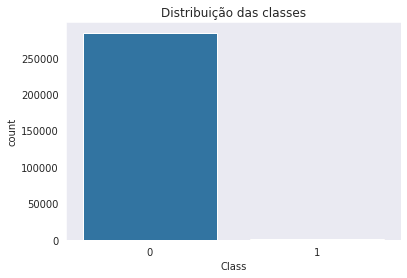

In [10]:
#Proporção das classes
print(df.Class.value_counts())
print('\nFraudes representam {:.4f}% do dataset.\n'.format((df[df.Class == 1].shape[0] / df.shape[0]) * 100))

#Gráfico de barras
fig, ax = plt.subplots()
sns.countplot('Class', data=df, ax=ax)
ax.set_title('Distribuição das classes')
plt.show()

Como as informações acima mostram, a grande maioria das entradas do dataset tem como valor de class 0, apenas 0.17% tem class 1.

**Relação entre Amount e Class**

Continuando a análise, vou plotar boxplots para verificar possível existencia de diferença no padrão das transações de acordo com as variaveis `Amount` e `Class`.

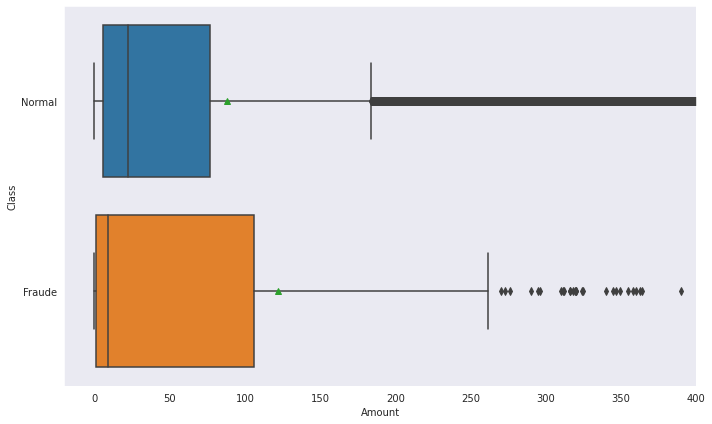

In [20]:
#Boxplots para Class e Amount
fig, ax = plt.subplots(figsize=(10, 6), sharey=True)

sns.boxplot(df.Amount, df.Class, showmeans=True, orient='h', ax=ax)
ax.set_xlim(((-20, 400)))
ax.set_yticks([0, 1])
ax.set_yticklabels(['Normal', 'Fraude'])
plt.tight_layout()

Percebe-se uma distribuição levemente diferente para as duas classes, o que provavelmente irá contribuir para o treinamento do modelo de machine learning.

Agora vamos ir mais afundo nas informações do Boxplot laranja acima, ou seja, as informações onde Class é 1 (operações fraudulentas) em comparação com a variável Amount, que nos diz a quantidade transacionada.

In [21]:
#Descrição das Transações Fraudulentas
df[df.Class == 1]['Amount'].describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

Podemos ver que quando as operações foram fraudulentas, tivemos uma media de 122, desvio padrão de 256 e um máximo de 2125 sendo negociado.

Importante lembrar que esses dados são de transações de cartões na europa, ou seja, provavelmente esses números são em euros.

**Gráfico de densidade.**

O gráfico de densidade é muito útil para compararmos as distribuições de cada variável para cada classe e ver quais as mais importantes para detecção de anomalias.

O que se procura nesse tipo de visualização são distribuições que diferem uma da outra, permitindo identificar fraudes mais facilmente. Veja como exemplo as variáveis V3, V4, V10 e V11, como elas são bem distintas.

Por outro lado, variáveis como V8, V13 e V15 são muito similares, apresentando aproximadamente o mesmo comportamento.

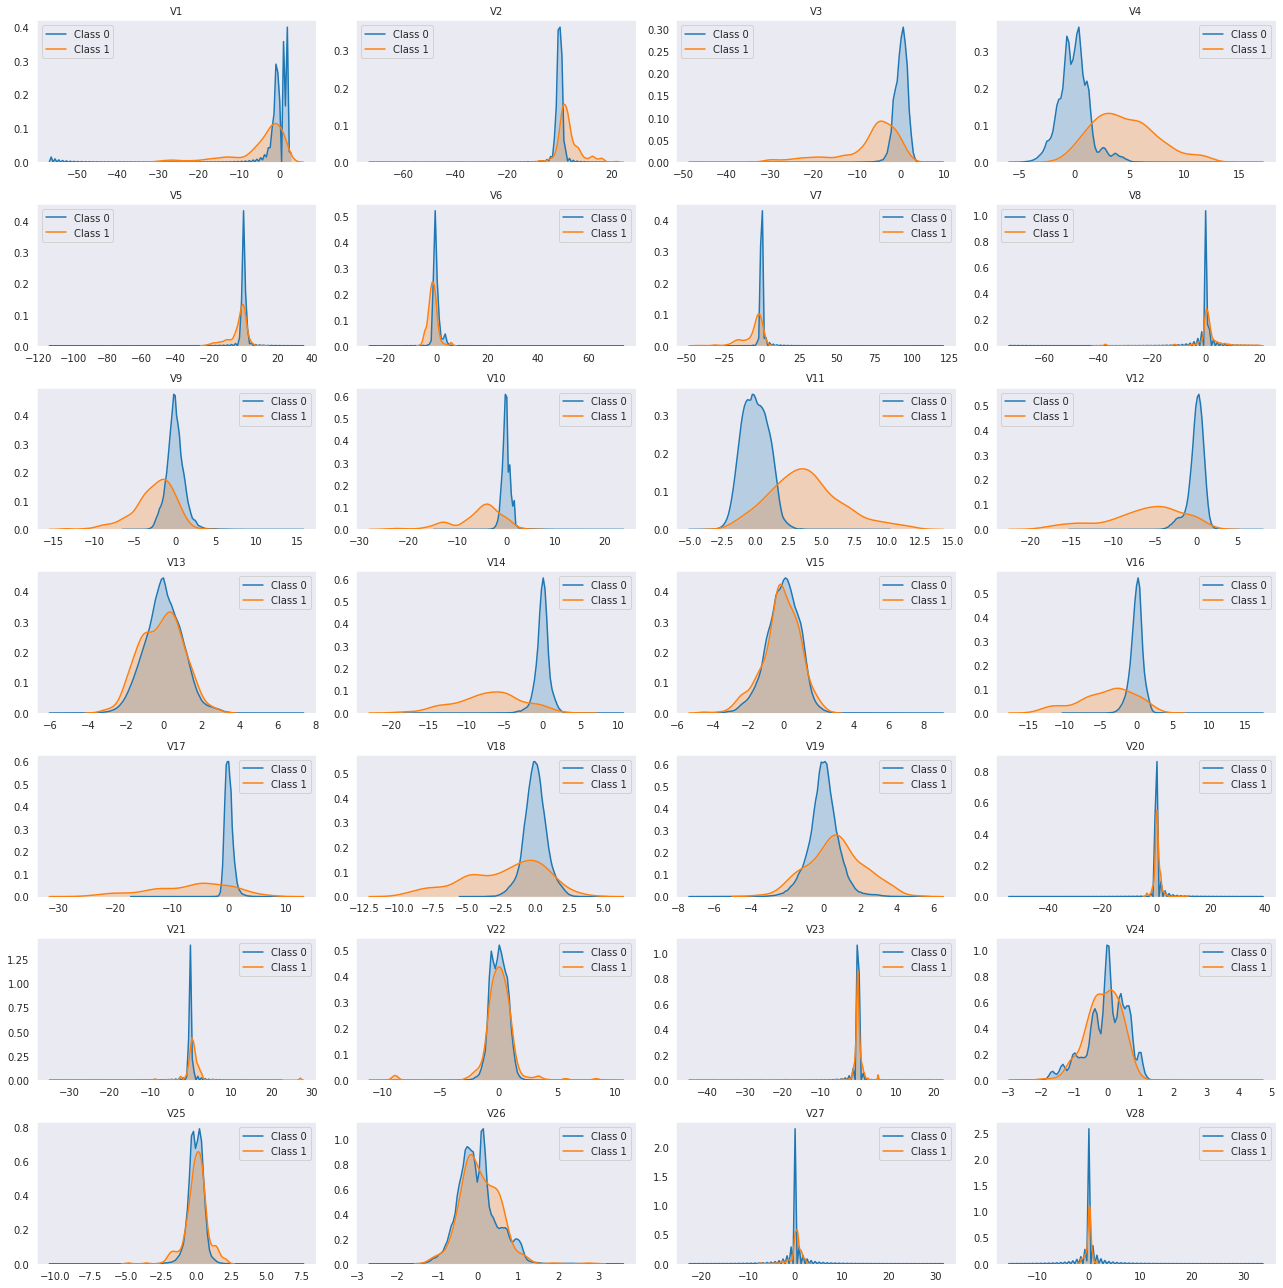

In [ ]:
#Plotando grádivos de densidade para as variáveis.
column_names = df.drop(['Class', 'Amount', 'Time'], axis=1).columns
num_plots = len(column_names)
df_class_0 = df[df.Class == 0]
df_class_1 = df[df.Class == 1]

fig, ax = plt.subplots(nrows=7, ncols=4, figsize=(18,18))
fig.subplots_adjust(hspace=1, wspace=1)

idx = 0
for col in column_names:
    idx += 1
    plt.subplot(7, 4, idx)
    sns.kdeplot(df_class_0[col], label="Class 0", shade=True)
    sns.kdeplot(df_class_1[col], label="Class 1", shade=True)
    plt.title(col, fontsize=10)
plt.tight_layout()

Resumidamente, algumas observações principais que puderam ser extraídas dessa etapa exploratória foram:

* O dataset está muito desbalanceado, uma vez que as transações fraudulentas representam apenas 0,17% das entradas totais.
* Não existem valores ausentes ou nulos no dataframe.
* Uma vez que a PCA é sensível à escala das variáveis, assume-se a premissa que as features originais foram padronizadas.
* As colunas Time e Amount não estão padronizadas.

## Preparação dos Dados

Já que as variáveis `Time` e `Amount` não estão padronizadas, farei isso agora.

Logo depois, irei:
* Dividir o conjunto de dados entre treino e teste
* Balancear o conjunto de dados

**Padronizar `Time` e `Amount`.**

In [24]:
#Padronizando Time e Amount.
df_clean = df.copy()

scaler = StandardScaler()
df_clean['std_amount'] = scaler.fit_transform(df_clean['Amount'].values.reshape(-1, 1))
df_clean['std_time'] = scaler.fit_transform(df_clean['Time'].values.reshape(-1, 1))

df_clean.drop(['Time', 'Amount'], axis=1, inplace=True)

df_clean.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,std_amount,std_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964,-1.996583
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475,-1.996583
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686,-1.996562
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534,-1.996562
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403,-1.996541


Acima podemos ver que agora as variáveis `Time` e `Amount` estão padronizadas em novas colunas chamadas `std_time` e `std_amount`.

**Separar entre conjunto de treino e teste.**

Seguindo a preparação, agora irei separar esse Dataset em treino e teste, assim poderei treinar o modelo de machine learning com os dados de treino e depois ver a eficiência nos dados de teste.

In [25]:
#Dividir em treino e teste

X = df_clean.drop('Class', axis=1)
y = df_clean.Class

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y, random_state=2)

**Balanceamento dos dados**

Usando a biblioteca imblearn é possível aplicar facilmente técnicas de balanceamento de dados. No caso, a opção neste projeto foi usar Under-sampling, preservando a classe minoritária.

É fácil ver que não há mais aquela discrepância inicial (gráfico de barras no início deste notebook).

1    369
0    369
dtype: int64


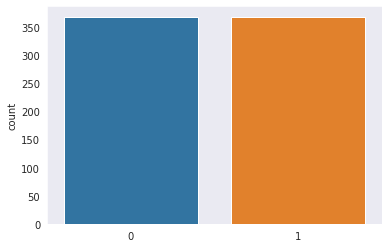

In [26]:
#Balancear dados
rus = RandomUnderSampler(random_state=2)
X_rus, y_rus = rus.fit_sample(X_train, y_train)

# ver o balanceamento das classes
print(pd.Series(y_rus).value_counts())

# plotar a nova distribuição de classes
sns.countplot(y_rus);

Agora que temos dados balanceados, podemos fazer uma matriz de correlação para ver quais variáveis estão mais relacionadas com outras.

Observe como anteriormente, sem o balanceamento de dados, a matriz de correlação não trazia nenhuma informação relevante. Entretanto, ela traz muito mais informações após um correto balanceamento.

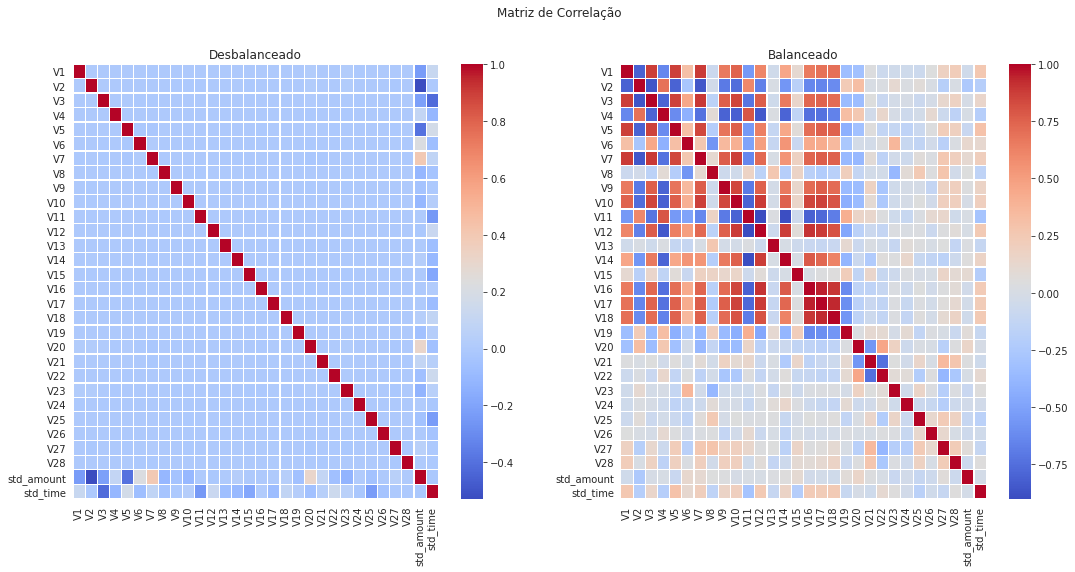

In [27]:
#matriz de correlação
corr = X_train.corr()
corr_rus = pd.DataFrame(X_rus).corr()


fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (18,8))
fig.suptitle('Matriz de Correlação')

sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,
            linewidths=.1, cmap="coolwarm", ax=ax[0])
ax[0].set_title('Desbalanceado')

sns.heatmap(corr_rus, xticklabels=corr.columns, yticklabels=corr.columns,
            linewidths=.1, cmap="coolwarm", ax=ax[1])
ax[1].set_title('Balanceado')

plt.show()

## Modelo de Machine Learning

Com todos os dados preparados e após uma análise exploratória completa, irei construir classificadores usando diferentes modelos de Machine learning.

Após instanciar o modelo, o mesmo será treinado em cima dos dados em X_rus e y_rus. Na sequência, serão realizadas as previsões sobre os dados de teste.

Segue abaixo 3 modelos diferentes com diferentes resultados.
* Primeiro uma Regressão Logística
* Depois um modelo de Árvore de Decisão
* Por último um modelo de KNN

Todos os modelos listados acima são modelos de Classificação, ou seja, eles aprendem com os dados de teste, e ao inserir novas informações eles retornam o resultado, que é uma classificação, ou seja, 0 ou 1 (Normal ou Fraude).

**Regressão Logística**

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.9999    0.9632    0.9812     71079
           1     0.0421    0.9350    0.0806       123

    accuracy                         0.9632     71202
   macro avg     0.5210    0.9491    0.5309     71202
weighted avg     0.9982    0.9632    0.9796     71202

Acurácia: 0.9632



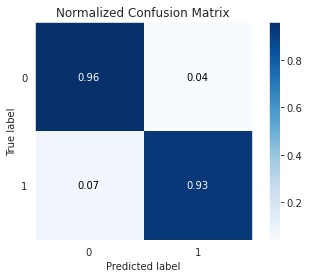

In [43]:
# 1º Modelo de Classificação (Regressão Logística)

#MODELO:
model1 = LogisticRegression()

model1.fit(X_rus, y_rus)

y_pred1 = model1.predict(X_test)


#AVALIAÇÃO DO MODELO:
# plotar a matrix de confusão
skplt.metrics.plot_confusion_matrix(y_test, y_pred1, normalize=True)

# imprimir relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_test, y_pred1, digits=4))

# imprimir a acurácia do modelo
print("Acurácia: {:.4f}\n".format(accuracy_score(y_test, y_pred1)))

**Árvore de Decisão**

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.9998    0.9637    0.9814     71079
           1     0.0413    0.9024    0.0789       123

    accuracy                         0.9636     71202
   macro avg     0.5205    0.9331    0.5302     71202
weighted avg     0.9982    0.9636    0.9799     71202

Acurácia: 0.9636



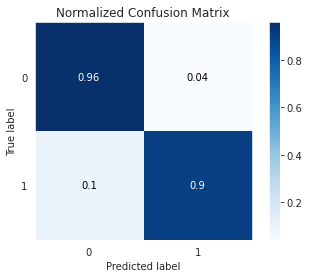

In [46]:
# 2º Modelo de Classificação (Arvore de Decisão)

#MODELO:
model2 = DecisionTreeClassifier(max_depth= 4, criterion='entropy')

model2.fit(X_rus, y_rus)

y_pred2 = model2.predict(X_test)


#AVALIAÇÃO DO MODELO:
# plotar a matrix de confusão
skplt.metrics.plot_confusion_matrix(y_test, y_pred2, normalize=True)

# imprimir relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_test, y_pred2, digits=4))

# imprimir a acurácia do modelo
print("Acurácia: {:.4f}\n".format(accuracy_score(y_test, y_pred2)))

**KNN Classifier**

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.9997    0.9993    0.9995     71079
           1     0.6753    0.8455    0.7509       123

    accuracy                         0.9990     71202
   macro avg     0.8375    0.9224    0.8752     71202
weighted avg     0.9992    0.9990    0.9991     71202

Acurácia: 0.9990



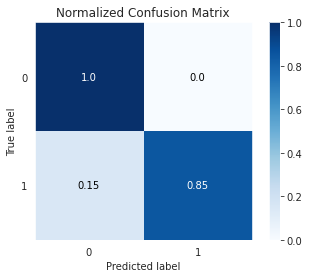

In [45]:
# 3º Modelo de Classificação (KNN)

#MODELO:
model3 = KNeighborsClassifier(n_neighbors=80)

model3.fit(X_rus, y_rus)

y_pred3 = model3.predict(X_test)


#AVALIAÇÃO DO MODELO:
# plotar a matrix de confusão
skplt.metrics.plot_confusion_matrix(y_test, y_pred3, normalize=True)

# imprimir relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_test, y_pred3, digits=4))

# imprimir a acurácia do modelo
print("Acurácia: {:.4f}\n".format(accuracy_score(y_test, y_pred3)))

Como as informações acima mostram, todos os 3 modelos tiveram alta acurácia, porém, acurácia não é sempre uma boa medida para qualidade.

Nos dois primeiros modelos, podemos ver que eles tiveram um `precision` para 1 (Fraude) muito baixo. Isso quer dizer que existem muitos Falsos Positivos, ou seja, há uma grande ocorrência de detectação de fraudes por parte do modelo, que na verdade não eram fraudes, gerando bloqueios de cartão desnecessários.

Por outro lado, tiveram bons recalls, que é a informação mais importante, pois um recall baixo significa alta quantidade de falsos negativos, ou seja, o modelo detectar que não é fraude, mas na verdade, é.

Melhor detectar uma fraude que na verdade não é nada do que o contrario né?

Mesmo assim, os precisions estarem muito baixos continua sendo prejudicial.

Já no terceiro modelo, o precision aumentou e o recall foi um pouco pior, mas no geral, melhor que os outros dois.

## Conclusão

Como se pode ver, o problema não é facil. Mesmo com um dataset limpo e organizado, sem valores categóricos ou ausentes.

Claramente, seria bom testar o desempenho com outros algoritmos de classificação, além de otimizar seus parâmetros.

Espero que tenham gostado do projeto!